# CNTK 301: Image Recognition with Deep Transfer Learning

This hands-on tutorial shows how to use [Transfer Learning](https://en.wikipedia.org/wiki/Inductive_transfer) to take an existing trained model and adapt it to your own specialized domain. Note: This notebook will run only if you have GPU enabled machine.

### Problem
You have been given a set of flower images that needs to be classified into their respective categories. Image below shows a sampling of the data source. 

![Flower image set](http://www.cntk.ai/jup/cntk301_Flowers.jpg)


However, the number of images is far less than what is needed to train a state-of-the-art classifier such as a [Residual Network](https://github.com/KaimingHe/deep-residual-networks). You have a rich annotated data set of images of natural scene images such as shown below (courtesy [t-SNE visualization site](http://cs.stanford.edu/people/karpathy/cnnembed/)).

![AlexNet data sample](http://www.cntk.ai/jup/cntk301_imagenet.jpg)

This tutorial introduces deep transfer learning as a means to leverage multiple data sources to overcome data scarcity problem.

### Why Transfer Learning?

As stated above, Transfer Learning is a useful technique when, for instance, you know you need to classify incoming images into different categories, but you do not have enough data to train a Deep Neural Network (DNN) from scratch. Training DNNs takes a lot of data, all of it labeled, and often you will not have that kind of data on hand. If your problem is similar to one for which a network has already been trained, though, you can use Transfer Learning to modify that network to your problem with a fraction of the labeled images (we are talking tens instead of thousands). 

### What is Transfer Learning?

With Transfer Learning, we use an existing trained model and adapt it to our own problem. We are essentially building upon the features and concepts that were learned during the training of the base model. With a Convolutional DNN (ResNet_18 in this case), we are using the features learned from ImageNet data and _cutting off_ the final classification layer, replacing it with a new dense layer that will predict the class labels of our new domain. 

The input to the old and the new prediction layer is the same, we simply reuse the trained features. Then we train this modified network, either only the new weights of the new prediction layer or all weights of the entire network.

This can be used, for instance, when we have a small set of images that are in a similar domain to an existing trained model. Training a Deep Neural Network from scratch requires tens of thousands of images, but training one that has already learned features in the domain you are adapting it to requires far fewer. 


In our case, this means adapting a network trained on ImageNet images (dogs, cats, birds, etc.) to flowers, or sheep/wolves. However, Transfer Learning has also been successfully used to adapt existing neural models for translation, speech synthesis, and many other domains - it is a convenient way to bootstrap your learning process.

### Importing CNTK and other useful libraries

Microsoft's Cognitive Toolkit comes in Python form as `cntk`, and contains many useful submodules for IO, defining layers, training models, and interrogating trained models. We will need many of these for Transfer Learning, as well as some other common libraries for downloading files, unpacking/unzipping them, working with the file system, and loading matrices.

In [42]:
from __future__ import print_function
import glob
import os
import numpy as np
from PIL import Image
# Some of the flowers data is stored as .mat files
from scipy.io import loadmat
from shutil import copyfile
import sys
import tarfile
import time

# Loat the right urlretrieve based on python version
try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve
    
import zipfile

# Useful for being able to dump images into the Notebook
import IPython.display as D

# Import CNTK and helpers
#import cntk
import cntk as C
# Load and convert data
#from cntk.io import MinibatchSource, ImageDeserializer, StreamDefs, StreamDef
#import cntk.io.transforms as xforms
#from cntk import load_model, combine, softmax, Trainer, UnitType,  CloneMethod
#rom cntk.layers import Dense
#rom cntk.learners import momentum_sgd, learning_rate_schedule, momentum_schedule
#rom cntk.losses import cross_entropy_with_softmax
#rom cntk.metrics import classification_error

#rom cntk.logging import log_number_of_parameters, ProgressPrinter
# Interrogate the Compute Graph to find the right layer in the trained model
#rom cntk.logging.graph import find_by_name, get_node_outputs

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

For *Fast mode* we train the model for 100 epochs and results have low accuracy but is good enough for development. The model yields good accuracy after 1000-2000 epochs.

In [43]:
isFast = True

### Downloading Data 

Now, let us download our datasets. We use two datasets in this tutorial - one containing _a bunch_ of flowers images, and the other containing _just a few_ sheep and wolves. They're described in more detail below, but what we are doing here is just downloading and unpacking them.

First in the section below we check if the notebook is running under internal test environment and if so download the data from a local cache.

Additionally, in this block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [44]:
C.device.try_set_default_device(C.device.gpu(0))

# Check for an environment variable defined in CNTK's test infrastructure
def is_test(): return 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY' in os.environ

# Select the right target device when this notebook is being tested
# Currently supported only for GPU 
# Setup data environment for pre-built data sources for testing
if is_test(): 
    if 'TEST_DEVICE' in os.environ:
        if os.environ['TEST_DEVICE'] == 'cpu':
            raise ValueError('This notebook is currently not support on CPU') 
        else:
            C.device.try_set_default_device(C.device.gpu(0))
    sys.path.append(os.path.join(*"../Tests/EndToEndTests/CNTKv2Python/Examples".split("/")))
    import prepare_test_data as T
    T.prepare_resnet_v1_model()
    T.prepare_flower_data()
    T.prepare_animals_data() 

Reusing cached file C:\repos\CNTK\Examples\Image\PretrainedModels\ResNet_18.model
Reusing cached file C:\repos\CNTK\Examples\Image\DataSets\Flowers\102flowers.tgz
Reusing cached file C:\repos\CNTK\Examples\Image\DataSets\Flowers\imagelabels.mat
Reusing cached file C:\repos\CNTK\Examples\Image\DataSets\Flowers\imagelabels.mat
Reusing cached file C:\repos\CNTK\Examples\Image\DataSets\Animals\Animals.zip


Note that we are setting the data root to coincide with the CNTK examples, so if you have run those some of the data might already exist. Alter the data root if you would like all of the input and output data to go elsewhere (i.e. if you have copied this notebook to your own space). The `download_unless_exists` method will try to download several times, but if that fails you might see an exception. It and the `write_to_file` method both - write to files, so if the data_root is not writeable or fills up you'll see exceptions there.

In [45]:
# By default, we store data in the Examples/Image directory under CNTK
# If you're running this _outside_ of CNTK, consider changing this
data_root = os.path.join('..', 'Examples', 'Image')
    
datasets_path = os.path.join(data_root, 'DataSets')
output_path = os.path.join('.', 'temp', 'Output')

def ensure_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def write_to_file(file_path, img_paths, img_labels):
    with open(file_path, 'w+') as f:
        for i in range(0, len(img_paths)):
            f.write('%s\t%s\n' % (os.path.abspath(img_paths[i]), img_labels[i]))

def download_unless_exists(url, filename, max_retries=3):
    '''Download the file unless it already exists, with retry. Throws if all retries fail.'''
    if os.path.exists(filename):
        print('Reusing locally cached: ', filename)
    else:
        print('Starting download of {} to {}'.format(url, filename))
        retry_cnt = 0
        while True:
            try:
                urlretrieve(url, filename)
                print('Download completed.')
                return
            except:
                retry_cnt += 1
                if retry_cnt == max_retries:
                    print('Exceeded maximum retry count, aborting.')
                    raise
                print('Failed to download, retrying.')
                time.sleep(np.random.randint(1,10))
        
def download_model(model_root = os.path.join(data_root, 'PretrainedModels')):
    ensure_exists(model_root)
    resnet18_model_uri = 'https://www.cntk.ai/Models/ResNet/ResNet_18.model'
    resnet18_model_local = os.path.join(model_root, 'ResNet_18.model')
    download_unless_exists(resnet18_model_uri, resnet18_model_local)
    return resnet18_model_local

def download_flowers_dataset(dataset_root = os.path.join(datasets_path, 'Flowers')):
    ensure_exists(dataset_root)
    flowers_uris = [
        'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz',
        'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat',
        'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
    ]
    flowers_files = [
        os.path.join(dataset_root, '102flowers.tgz'),
        os.path.join(dataset_root, 'imagelabels.mat'),
        os.path.join(dataset_root, 'setid.mat')
    ]
    for uri, file in zip(flowers_uris, flowers_files):
        download_unless_exists(uri, file)
    tar_dir = os.path.join(dataset_root, 'extracted')
    if not os.path.exists(tar_dir):
        print('Extracting {} to {}'.format(flowers_files[0], tar_dir))
        os.makedirs(tar_dir)
        tarfile.open(flowers_files[0]).extractall(path=tar_dir)
    else:
        print('{} already extracted to {}, using existing version'.format(flowers_files[0], tar_dir))

    flowers_data = {
        'data_folder': dataset_root,
        'training_map': os.path.join(dataset_root, '6k_img_map.txt'),
        'testing_map': os.path.join(dataset_root, '1k_img_map.txt'),
        'validation_map': os.path.join(dataset_root, 'val_map.txt')
    }
    
    if not os.path.exists(flowers_data['training_map']):
        print('Writing map files ...')
        # get image paths and 0-based image labels
        image_paths = np.array(sorted(glob.glob(os.path.join(tar_dir, 'jpg', '*.jpg'))))
        image_labels = loadmat(flowers_files[1])['labels'][0]
        image_labels -= 1

        # read set information from .mat file
        setid = loadmat(flowers_files[2])
        idx_train = setid['trnid'][0] - 1
        idx_test = setid['tstid'][0] - 1
        idx_val = setid['valid'][0] - 1

        # Confusingly the training set contains 1k images and the test set contains 6k images
        # We swap them, because we want to train on more data
        write_to_file(flowers_data['training_map'], image_paths[idx_train], image_labels[idx_train])
        write_to_file(flowers_data['testing_map'], image_paths[idx_test], image_labels[idx_test])
        write_to_file(flowers_data['validation_map'], image_paths[idx_val], image_labels[idx_val])
        print('Map files written, dataset download and unpack completed.')
    else:
        print('Using cached map files.')
        
    return flowers_data
    
def download_animals_dataset(dataset_root = os.path.join(datasets_path, 'Animals')):
    ensure_exists(dataset_root)
    animals_uri = 'https://www.cntk.ai/DataSets/Animals/Animals.zip'
    animals_file = os.path.join(dataset_root, 'Animals.zip')
    download_unless_exists(animals_uri, animals_file)
    if not os.path.exists(os.path.join(dataset_root, 'Test')):
        with zipfile.ZipFile(animals_file) as animals_zip:
            print('Extracting {} to {}'.format(animals_file, dataset_root))
            animals_zip.extractall(path=os.path.join(dataset_root, '..'))
            print('Extraction completed.')
    else:
        print('Reusing previously extracted Animals data.')
        
    return {
        'training_folder': os.path.join(dataset_root, 'Train'),
        'testing_folder': os.path.join(dataset_root, 'Test')
    }

print('Downloading flowers and animals data-set, this might take a while...')
flowers_data = download_flowers_dataset()
animals_data = download_animals_dataset()
print('All data now available to the notebook!')

Reusing locally cached:  ..\Examples\Image\DataSets\Flowers\102flowers.tgz
Reusing locally cached:  ..\Examples\Image\DataSets\Flowers\imagelabels.mat
Reusing locally cached:  ..\Examples\Image\DataSets\Flowers\setid.mat
..\Examples\Image\DataSets\Flowers\102flowers.tgz already extracted to ..\Examples\Image\DataSets\Flowers\extracted, using existing version
Using cached map files.
Reusing locally cached:  ..\Examples\Image\DataSets\Animals\Animals.zip
Reusing previously extracted Animals data.
All data now available to the notebook!


### Trained Model Architecture

For this task, we have chosen ResNet_18 as our trained model and  will it as the base model. This model will be adapted using Transfer Learning for classification of flowers and animals. This model is a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) built using [Residual Network](https://github.com/KaimingHe/deep-residual-networks) techniques. Convolutional Neural Networks build up layers of convolutions, transforming an input image and distilling it down until they start recognizing composite features, with deeper layers of convolutions recognizing complex patterns are made possible. The author of Keras has a [fantastic post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) where he describes how Convolutional Networks "see the world" which gives a much more detailed explanation.

Residual Deep Learning is a technique that originated in Microsoft Research and involves "passing through" the main signal of the input data, so that the network winds up "learning" on just the residual portions that differ between layers. This has proven, in practice, to allow the training of much deeper networks by avoiding issues that plague gradient descent on larger networks. These cells bypass convolution layers and then come back in later before ReLU (see below), but some have argued that even deeper networks can be built by avoiding even more nonlinearities in the bypass channel. This is an area of hot research right now, and one of the most exciting parts of Transfer Learning is that you get to benefit from all of the improvements by just integrating new trained models.

![A ResNet Block](https://adeshpande3.github.io/assets/ResNet.png)

For visualizations of some of the deeper ResNet architectures, see [Kaiming He's GitHub](https://github.com/KaimingHe/deep-residual-networks) where he links off to visualizations of 50, 101, and 152-layer architectures.

In [46]:
print('Downloading pre-trained model. Note: this might take a while...')
base_model_file = download_model()
print('Downloading pre-trained model complete!')

Reusing locally cached:  ..\Examples\Image\PretrainedModels\ResNet_18.model


### Interrogating the Model

We print out all of the layers in ResNet_18 to show you how you can interrogate a model - to use a different model than ResNet_18 you would just need to discover the appropriate last hidden layer and feature layer to use. CNTK provides a convenient `get_node_outputs` method under `cntk.graph` to allow you to dump all of the model details. We can recognize the final hidden layer as the one before we start computing the final classification into the 1000 ImageNet classes (so in this case, `z.x`).

In [47]:
# define base model location and characteristics
base_model = {
    'model_file': base_model_file,
    'feature_node_name': 'features',
    'last_hidden_node_name': 'z.x',
    # Channel Depth x Height x Width
    'image_dims': (3, 224, 224)
}

# Print out all layers in the model
print('Loading {} and printing all layers:'.format(base_model['model_file']))
node_outputs = C.logging.get_node_outputs(C.load_model(base_model['model_file']))
for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

Loading ..\Examples\Image\PretrainedModels\ResNet_18.model and printing all layers:
  ce ()
  errs ()
  top5Errs ()
  z (1000,)
  ce ()
  z (1000,)
  z.PlusArgs[0] (1000,)
  z.x (512, 1, 1)
  z.x.x.r (512, 7, 7)
  z.x.x.p (512, 7, 7)
  z.x.x.b (512, 7, 7)
  z.x.x.b.x.c (512, 7, 7)
  z.x.x.b.x (512, 7, 7)
  z.x.x.b.x._ (512, 7, 7)
  z.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.r (512, 7, 7)
  z.x.x.x.p (512, 7, 7)
  z.x.x.x.b (512, 7, 7)
  z.x.x.x.b.x.c (512, 7, 7)
  z.x.x.x.b.x (512, 7, 7)
  z.x.x.x.b.x._ (512, 7, 7)
  z.x.x.x.b.x._.x.c (512, 7, 7)
  _z.x.x.x.r (512, 7, 7)
  _z.x.x.x.p (512, 7, 7)
  _z.x.x.x.b (512, 7, 7)
  _z.x.x.x.b.x.c (512, 7, 7)
  _z.x.x.x.b.x (512, 7, 7)
  _z.x.x.x.b.x._ (512, 7, 7)
  _z.x.x.x.b.x._.x.c (512, 7, 7)
  z.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.p (256, 14, 14)
  z.x.x.x.x.b (256, 14, 14)
  z.x.x.x.x.b.x.c (256, 14, 14)
  z.x.x.x.x.b.x (256, 14, 14)
  z.x.x.x.x.b.x._ (256, 14, 14)
  z.x.x.x.x.b.x._.x.c (256, 14, 14)
  z.x.x.x.x.x.r (256, 14, 14)
  z.x.x.x.x.x.p

### The Flowers Dataset

The Flowers dataset comes from the Oxford Visual Geometry Group, and contains 102 different categories of flowers common to the UK. It has roughly 8000 images split between train, test, and validation sets. The [VGG homepage for the dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) contains more details.

The data comes in the form of a huge [tarball](https://en.wikipedia.org/wiki/Tar_(computing)) of images, and two matrices in `.mat` format. These are 1-based matrices containing label IDs and the train/test/validation split. We convert them to 0-based labels, and write out the train, test, and validation index files in the format CNTK expects (see `write_to_file` above) of image/label pairs (tab-delimited, one per line).

Let's take a look at some of the data we'll be working with:

In [48]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin = 0, vmax = 1.0, cmap = 'gray')
        ax.axis('off')
    plt.show()

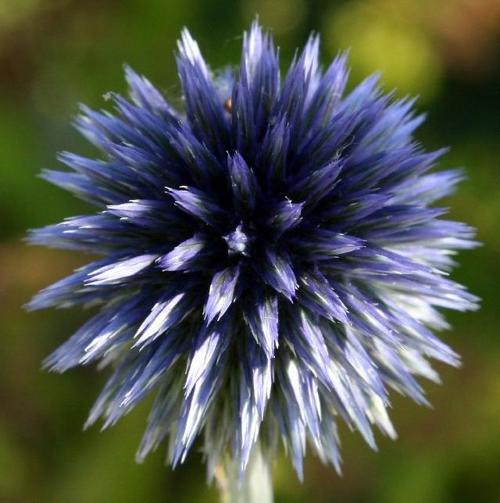

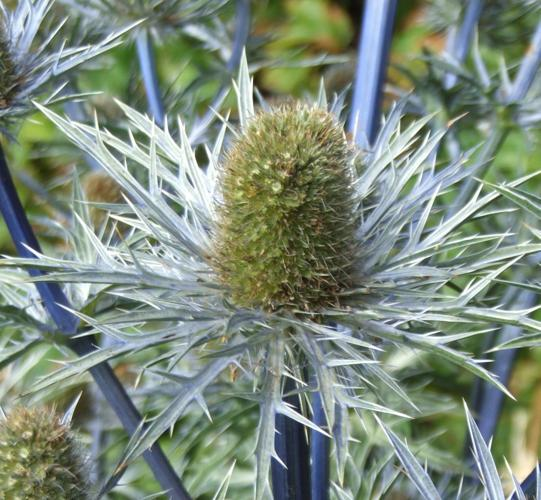

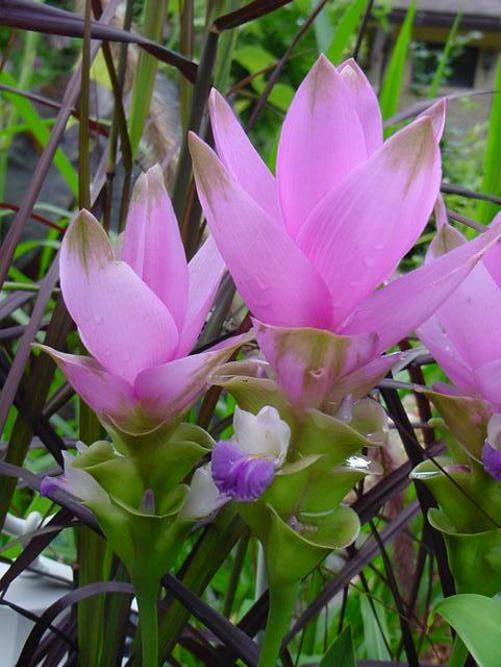

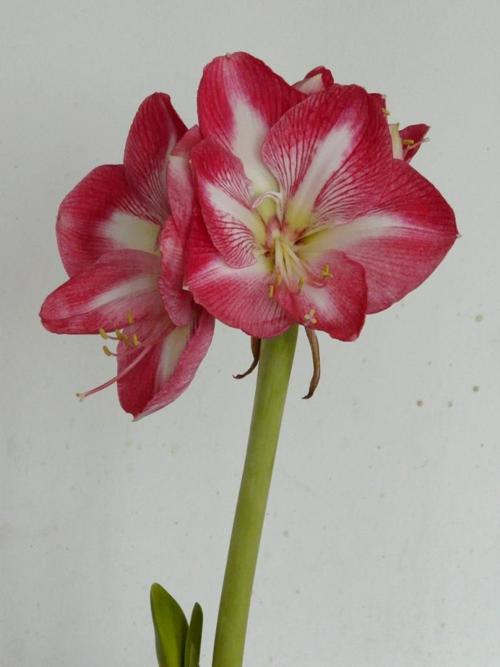

In [49]:
flowers_image_dir = os.path.join(flowers_data['data_folder'], 'extracted', 'jpg')


for image in ['08093', '08084', '08081', '08058']:
    D.display(D.Image(os.path.join(flowers_image_dir, 'image_{}.jpg'.format(image)), width=100, height=100))

### Training the Transfer Learning Model

In the code below, we load up the pre-trained ResNet_18 model and clone it, while stripping off the final `features` layer. We clone the model so that we can re-use the same trained model multiple times, trained for different things - it is not strictly necessary if you are just training it for a single task, but this is why we would not use `CloneMethod.share`, we want to learn new parameters. If `freeze_weights` is true, we will freeze weights on all layers we clone and only learn weights on the final new features layer. This can often be useful if you are cloning higher up the tree (e.g., cloning after the first convolutional layer to just get basic image features).

We find the final hidden layer (`z.x`) using `find_by_name`, clone it and all of its predecessors, then attach a new `Dense` layer for classification.

In [50]:
import cntk.io.transforms as xforms
ensure_exists(output_path)
np.random.seed(123)

# Creates a minibatch source for training or testing
def create_mb_source(map_file, image_dims, num_classes, randomize=True):
    transforms = [xforms.scale(width=image_dims[2], height=image_dims[1], channels=image_dims[0], interpolations='linear')]
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
            features=C.io.StreamDef(field='image', transforms=transforms),
            labels=C.io.StreamDef(field='label', shape=num_classes))),
            randomize=randomize)

# Creates the network model for transfer learning
def create_model(model_details, num_classes, input_features, new_prediction_node_name='prediction', freeze=False):
    # Load the pretrained classification net and find nodes
    base_model = C.load_model(model_details['model_file'])
    feature_node = C.logging.find_by_name(base_model, model_details['feature_node_name'])
    last_node = C.logging.find_by_name(base_model, model_details['last_hidden_node_name'])

    # Clone the desired layers with fixed weights
    cloned_layers = C.combine([last_node.owner]).clone(
        C.CloneMethod.freeze if freeze else C.CloneMethod.clone,
        {feature_node: C.placeholder(name='features')})

    # Add new dense layer for class prediction
    feat_norm = input_features - C.Constant(114)
    cloned_out = cloned_layers(feat_norm)
    z = C.layers.Dense(num_classes, activation=None, name=new_prediction_node_name) (cloned_out)

    return z

We will now train the model just like any other CNTK model training - instantiating an input source (in this case a `MinibatchSource` from our image data), defining the loss function, and training for a number of epochs. Since we are training a multi-class classifier network, the final layer is a cross-entropy Softmax, and the error function is classification error - both conveniently provided by utility functions in `cntk.ops`.

When training a pre-trained model, we are adapting the existing weights to suit our domain. Since the weights are likely already close to correct (especially for earlier layers that find more primitive features), fewer examples and fewer epochs are typically required to get good performance.

In [51]:
# Trains a transfer learning model
def train_model(model_details, num_classes, train_map_file,
                learning_params, max_images=-1):
    num_epochs = learning_params['max_epochs']
    epoch_size = sum(1 for line in open(train_map_file))
    if max_images > 0:
        epoch_size = min(epoch_size, max_images)
    minibatch_size = learning_params['mb_size']
    
    # Create the minibatch source and input variables
    minibatch_source = create_mb_source(train_map_file, model_details['image_dims'], num_classes)
    image_input = C.input(model_details['image_dims'])
    label_input = C.input(num_classes)

    # Define mapping from reader streams to network inputs
    input_map = {
        image_input: minibatch_source['features'],
        label_input: minibatch_source['labels']
    }

    # Instantiate the transfer learning model and loss function
    tl_model = create_model(model_details, num_classes, image_input, freeze=learning_params['freeze_weights'])
    ce = C.cross_entropy_with_softmax(tl_model, label_input)
    pe = C.classification_error(tl_model, label_input)

    # Instantiate the trainer object
    lr_schedule = C.learning_rate_schedule(learning_params['lr_per_mb'], unit=C.UnitType.minibatch)
    mm_schedule = C.momentum_schedule(learning_params['momentum_per_mb'])
    learner = C.momentum_sgd(tl_model.parameters, lr_schedule, mm_schedule, 
                           l2_regularization_weight=learning_params['l2_reg_weight'])
    trainer = C.Trainer(tl_model, (ce, pe), learner)

    # Get minibatches of images and perform model training
    print("Training transfer learning model for {0} epochs (epoch_size = {1}).".format(num_epochs, epoch_size))
    C.logging.log_number_of_parameters(tl_model)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=num_epochs)
    for epoch in range(num_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = minibatch_source.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map)
            trainer.train_minibatch(data)                                    # update model with it
            sample_count += trainer.previous_minibatch_sample_count          # count samples processed so far
            progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
            if sample_count % (100 * minibatch_size) == 0:
                print ("Processed {0} samples".format(sample_count))

        progress_printer.epoch_summary(with_metric=True)

    return tl_model

When we evaluate the trained model on an image, we have to massage that image into the expected format. In our case we use `Image` to load the image from its path, resize it to the size expected by our model, reverse the color channels (RGB to BGR), and convert to a contiguous array along height, width, and color channels. This corresponds to the 224x224x3 flattened array on which our model was trained.

The model with which we are doing the evaluation has not had the Softmax and Error layers added, so is complete up to the final feature layer. To evaluate the image with the model, we send the input data to the `model.eval` method, `softmax` over the results to produce probabilities, and use Numpy's `argmax` method to determine the predicted class. We can then compare that against the true labels to get the overall model accuracy.

In [52]:
# Evaluates a single image using the re-trained model
def eval_single_image(loaded_model, image_path, image_dims):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image.open(image_path)
        
        if image_path.endswith("png"):
            temp = Image.new("RGB", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.resize((image_dims[2], image_dims[1]), Image.ANTIALIAS)
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']
        


# Evaluates an image set using the provided model
def eval_test_images(loaded_model, output_file, test_map_file, image_dims, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    if isFast:
        num_images = min(num_images, 300) #We will run through fewer images for test run
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(output_file, 'wb') as results_file:
        with open(test_map_file, "r") as input_file:
            for line in input_file:
                tokens = line.rstrip().split('\t')
                img_file = tokens[0 + column_offset]
                probs = eval_single_image(loaded_model, img_file, image_dims)
                
                if probs[0]=='None':
                    print("Eval not possible: ", img_file)
                    continue

                pred_count += 1
                true_label = int(tokens[1 + column_offset])
                predicted_label = np.argmax(probs)
                if predicted_label == true_label:
                    correct_count += 1

                #np.savetxt(results_file, probs[np.newaxis], fmt="%.3f")
                if pred_count % 100 == 0:
                    print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                           (float(correct_count) / pred_count)))
                if pred_count >= num_images:
                    break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

Finally, with all of these helper functions in place we can train the model and evaluate it on our flower dataset.

Feel free to adjust the `learning_params` below and observe the results. You can tweak the `max_epochs` to train for longer, `mb_size` to adjust the size of each minibatch, or `lr_per_mb` to play with the speed of convergence (learning rate). 

**Note that if you've already trained the model, you will want to set `force_retraining` to `True` to force the Notebook to re-train your model with the new parameters.** 

You should see the model train and evaluate, with a final accuracy somewhere in the realm of 94%. At this point you could choose to train longer, or consider taking a look at the confusion matrix to determine if certain flowers are mis-predicted at a greater rate. You could also easily swap out to a different model and see if that performs better, or potentially learn from an earlier point in the model architecture.

In [53]:
force_retraining = True

max_training_epochs = 5 if isFast else 20

learning_params = {
    'max_epochs': max_training_epochs,
    'mb_size': 50,
    'lr_per_mb': [0.2]*10 + [0.1],
    'momentum_per_mb': 0.9,
    'l2_reg_weight': 0.0005,
    'freeze_weights': True
}

flowers_model = {
    'model_file': os.path.join(output_path, 'FlowersTransferLearning.model'),
    'results_file': os.path.join(output_path, 'FlowersPredictions.txt'),
    'num_classes': 102
}

# Train only if no model exists yet or if force_retraining is set to True
if os.path.exists(flowers_model['model_file']) and not force_retraining:
    print("Loading existing model from %s" % flowers_model['model_file'])
    trained_model = C.load_model(flowers_model['model_file'])
else:
    trained_model = train_model(base_model,
                                flowers_model['num_classes'], flowers_data['training_map'],
                                learning_params)
    trained_model.save(flowers_model['model_file'])
    print("Stored trained model at %s" % flowers_model['model_file'])

Training transfer learning model for 5 epochs (epoch_size = 6149).
Training 52326 parameters in 2 parameter tensors.


RuntimeError: Batch normalization training on CPU is not yet implemented.

[CALL STACK]
    > Microsoft::MSR::CNTK::CPUMatrix<float>::  BatchNormalizationForward
    - Microsoft::MSR::CNTK::Matrix<float>::  BatchNormalizationForward
    - Microsoft::MSR::CNTK::CntkBatchNormEngine<float>::  ForwardCore
    - Microsoft::MSR::CNTK::BatchNormalizationNode<float>::  ForwardPropNonLooping
    - Microsoft::MSR::CNTK::ComputationNodeNonLooping<double>::  ForwardProp
    - Microsoft::MSR::CNTK::ComputationNetwork::PARTraversalFlowControlNode::  ForwardProp
    - <lambda_258018e62e82ba6c7f6055b001fc29b8>::  operator  ()
    - Microsoft::MSR::CNTK::ComputationNetwork::TravserseInSortedGlobalEvalOrder<std::vector<std::shared_ptr<Microsoft::MSR::CNTK::ComputationNodeBase>,std::allocator<std::shared_ptr<Microsoft::MSR::CNTK::ComputationNodeBase>>>>  
    - CNTK::CompositeFunction::  Forward
    - CNTK::Function::  Forward
    - CNTK::Trainer::  ExecuteForwardBackward
    - CNTK::Trainer::  TrainLocalMinibatch
    - CNTK::Trainer::  TrainMinibatch (x2)
    - _wrap_Trainer_train_minibatch_overload_for_minibatchdata__SWIG_0
    - _wrap_Trainer_train_minibatch_overload_for_minibatchdata



In [ ]:
# Evaluate the test set
predict_correct, predict_total, predict_accuracy = \
   eval_test_images(trained_model, flowers_model['results_file'], flowers_data['testing_map'], base_model['image_dims'])
print("Done. Wrote output to %s" % flowers_model['results_file'])

In [ ]:
# Test: Accuracy on flower data
print ("Prediction accuracy: {0:.2%}".format(float(predict_correct) / predict_total))

### Animals Dataset

With the Flowers dataset, we had hundreds of classes with hundreds of images. What if we had a smaller set of classes and images to work with, would transfer learning still work? Let us examine the Animals dataset we have downloaded, consisting of nothing but sheep and wolves and a much smaller set of images to work with (on the order of a dozen per class). Let us take a look at a few...

In [ ]:
sheep = ['738519_d0394de9.jpg', 'Pair_of_Icelandic_Sheep.jpg']
wolves = ['European_grey_wolf_in_Prague_zoo.jpg', 'Wolf_je1-3.jpg']
for image in [os.path.join('Sheep', f) for f in sheep] + [os.path.join('Wolf', f) for f in wolves]:
    D.display(D.Image(os.path.join(animals_data['training_folder'], image), width=100, height=100))

The images are stored in `Train` and `Test` folders with the nested folder giving the class name (i.e. `Sheep` and `Wolf` folders). This is quite common, so it is useful to know how to convert that format into one that can be used for constructing the mapping files CNTK expects. `create_class_mapping_from_folder` looks at all nested folders in the root and turns their names into labels, and returns this as an array used by `create_map_file_from_folder`. That method walks those folders and writes their paths and label indices into a `map.txt` file in the root (e.g. `Train`, `Test`). Note the use of `abspath`, allowing you to specify relative "root" paths to the method, and then move the resulting map files or run from different directories without issue. 

In [ ]:
# Set python version variable 
python_version = sys.version_info.major

def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False, valid_extensions=['.jpg', '.jpeg', '.png']):
    map_file_name = os.path.join(root_folder, "map.txt")
    
    map_file = None

    if python_version == 3: 
        map_file = open(map_file_name , 'w', encoding='utf-8')
    else:
        map_file = open(map_file_name , 'w')

    for class_id in range(0, len(class_mapping)):
        folder = os.path.join(root_folder, class_mapping[class_id])
        if os.path.exists(folder):
            for entry in os.listdir(folder):
                filename = os.path.abspath(os.path.join(folder, entry))
                if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                    try:
                        map_file.write("{0}\t{1}\n".format(filename, class_id))
                    except UnicodeEncodeError:
                        continue

    if include_unknown:
        for entry in os.listdir(root_folder):
            filename = os.path.abspath(os.path.join(root_folder, entry))
            if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                try:
                    map_file.write("{0}\t-1\n".format(filename))
                except UnicodeEncodeError:
                    continue
                    
    map_file.close()  
    
    return map_file_name
  

def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    return np.asarray(classes)

animals_data['class_mapping'] = create_class_mapping_from_folder(animals_data['training_folder'])
animals_data['training_map'] = create_map_file_from_folder(animals_data['training_folder'], animals_data['class_mapping'])
# Since the test data includes some birds, set include_unknown
animals_data['testing_map'] = create_map_file_from_folder(animals_data['testing_folder'], animals_data['class_mapping'], 
                                                          include_unknown=True)

We can now train our model on our small domain and evaluate the results:

In [ ]:
animals_model = {
    'model_file': os.path.join(output_path, 'AnimalsTransferLearning.model'),
    'results_file': os.path.join(output_path, 'AnimalsPredictions.txt'),
    'num_classes': len(animals_data['class_mapping'])
}

if os.path.exists(animals_model['model_file']) and not force_retraining:
    print("Loading existing model from %s" % animals_model['model_file'])
    trained_model = C.load_model(animals_model['model_file'])
else:
    trained_model = train_model(base_model, 
                                animals_model['num_classes'], animals_data['training_map'],
                                learning_params)
    trained_model.save(animals_model['model_file'])
    print("Stored trained model at %s" % animals_model['model_file'])

Now that the model is trained for animals data. Lets us evaluate the images.

In [ ]:
# evaluate test images
with open(animals_data['testing_map'], 'r') as input_file:
    for line in input_file:
        tokens = line.rstrip().split('\t')
        img_file = tokens[0]
        true_label = int(tokens[1])
        probs = eval_single_image(trained_model, img_file, base_model['image_dims'])

        if probs[0]=='None':
            continue
        class_probs = np.column_stack((probs, animals_data['class_mapping'])).tolist()
        class_probs.sort(key=lambda x: float(x[0]), reverse=True)
        predictions = ' '.join(['%s:%.3f' % (class_probs[i][1], float(class_probs[i][0])) \
                                for i in range(0, animals_model['num_classes'])])
        true_class_name = animals_data['class_mapping'][true_label] if true_label >= 0 else 'unknown'
        print('Class: %s, predictions: %s, image: %s' % (true_class_name, predictions, img_file))

### The Known Unknown

Note the `include_unknown=True` in the `test_map_file` creation. This is because we have a few unlabeled images in that directory - these get tagged with label `-1`, which will never be matched by the evaluator. This is just to show that if you train a classifier to only find sheep and wolves, it will always find sheep and wolves. Showing it pictures of birds like our unknown examples will only result in confusion, as you can see above where the images of birds are falsely predicted.

In [ ]:
images = ['Bird_in_flight_wings_spread.jpg', 'quetzal-bird.jpg', 'Weaver_bird.jpg']
for image in images:
    D.display(D.Image(os.path.join(animals_data['testing_folder'], image), width=100, height=100))

### Final Thoughts, and Caveats

Transfer Learning has limitations. If you noticed, we re-trained a model that had been trained on ImageNet images. This meant it already _knew_ what "images" were, and had a good idea on concepts from low-level (stripes, circles) to high-level (dog's noses, cat's ears). Re-training such a model to detect sheep or wolves makes sense, but re-training it to detect vehicles from aerial imagery would be more difficult. You can still use Transfer Learning in these cases, but you might want to just re-use earlier layers of the model (i.e. the early Convolutional layers that have learned more primitive concepts), and you will likely require much more training data.

Adding a catch-all category can be a good idea, but only if the training data for that category contains images that are again sufficiently similar to the images you expect at scoring time. As in the above example, if we train a classifier with images of sheep and wolf and use it to score an image of a bird, the classifier can still only assign a sheep or wolf label, since it does not know any other categories. If we were to add a catch-all category and add training images of birds to it then the classifier might predict the class correctly for the bird image. However, if we present it, e.g., an image of a car, it faces the same problem as before as it knows only sheep, wolf and bird (which we just happened to call called catch-all). Hence, your training data, even for your catch-all, needs to cover sufficiently those concepts and images that you expect later on at scoring time.